Данный ноутбук сделан по мотивам [How Contextual are Contextualized Word Representations?
Comparing the Geometry of BERT, ELMo, and GPT-2 Embeddings](https://arxiv.org/pdf/1909.00512.pdf)

Автор ноутбука: Александра Коган БПМИ-182

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 33.9 MB/s 
     |████████████████████████████████| 895 kB 55.5 MB/s 
     |████████████████████████████████| 636 kB 64.6 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
import torch
import numpy as np

In [ ]:
#Загружаем модели BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
bert_model = BertModel.from_pretrained('bert-base-cased')
_ = bert_model.eval()

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Загружаем модели GPT2
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2Model.from_pretrained('gpt2')
_ = gpt2_model.eval()

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
def get_bert_embeddings(sentence):
		
		# Добавляем дополнительные токены
		tokens = ['[CLS]'] + bert_tokenizer.tokenize(sentence) + ['[SEP]']

		# Токенизируем  BERT токенайзером, получая индексы токенов в словаре, и превращаем в тензор
		token_ids = bert_tokenizer.convert_tokens_to_ids(tokens) 
		tokens_tensor = torch.tensor([token_ids])
	
		with torch.no_grad():
      #Получаем tuple из тензоров shape - (batch_size, sequence_length, hidden_size)
			_,_, embeddings = bert_model(tokens_tensor,  output_hidden_states=True, return_dict=False)

		#Шаманим, превращая tuple в тензор, удаляя эмбеддинги для ненужных токенов
		embeddings = torch.stack(list(embeddings),dim=0).squeeze()[:,1:-1,:]
    #Делаем это все numpy
		embeddings = embeddings.detach().numpy()							

    #Вернем токены предложения и эмбеддинги
		return tokens[1:-1], embeddings

Теперь можно получить список токенов (это полезно, так как не всегда токен соответствует одному слову) и 3-х мерный массив:



*   dim = 0 - по слоям модели ([0] - входные эмбеддинги, [1 : 12] - после слоев)
*   dim = 1 - по токенам в предложении
*   dim = 2 - размерность эмбеддиногов (BERT - 768) 



In [ ]:
#Пример
tok, embs = get_bert_embeddings('I love embeddings')
print('All tokens = ', tok)
print('Len of sentence = ', len(tok))
print('Shape of embedding tensor = ', embs.shape)

All tokens =  ['I', 'love', 'em', '##bed', '##ding', '##s']
Len of sentence =  6
Shape of embedding tensor =  (13, 6, 768)


In [ ]:
def get_gpt2_embeddings(sentence):

    tokens =  gpt2_tokenizer.tokenize(sentence) 
  
    # Токенизируем  gpt2 токенайзером, получая индексы токенов в словаре, и превращаем в тензор
    token_ids = gpt2_tokenizer.convert_tokens_to_ids(tokens)
    
    tokens_tensor = torch.tensor([token_ids])
    with torch.no_grad():
        #Получаем tuple из тензоров shape - (batch_size, sequence_length, hidden_size)
			  _,_, embeddings = gpt2_model(tokens_tensor,  output_hidden_states=True, return_dict=False)

		#Шаманим, превращая tuple в тензор
    embeddings = torch.stack(list(embeddings),dim=0).squeeze()
    #Делаем это все numpy
    embeddings = embeddings.detach().numpy()							

    #Вернем токены предложения и эмбеддинги
    return tokens, embeddings

In [ ]:
#Пример
tok, embs = get_gpt2_embeddings('I love embeddings')
print('All tokens = ', tok)
print('Len of sentence = ', len(tok))
print('Shape of embedding tensor = ', embs.shape)

All tokens =  ['I', 'Ġlove', 'Ġembed', 'd', 'ings']
Len of sentence =  5
Shape of embedding tensor =  (13, 5, 768)


Теперь нужен корпус. Возьмем небольшой корпус предложений https://www.score-corpus.org/en/

In [ ]:
import pandas as pd
corpus = pd.read_excel('SCoRE Example Data.xls')['example'].apply(lambda x: x.replace('{', '').replace('}','')).values

In [ ]:
corpus[9]

"Liam's pie is better than that of Kyle's."

Начнем с косинусной близости случайно взятых токенов. (Рисунок 1)

Также это значение будет использоватеься в качестве baseline (формула 3.4)

Все это должно высчитываться пробегом по всему корпусу, но ввиду ограниченного времени и мощности, проведем процедуру несколько раз (n_runs в сигнатуре функции)

In [ ]:
#Для воспроизводимости
np.random.seed(27)

In [ ]:
#Функция для подсчета косинусной близости случайных слов
def similarity_random_words(corpus, get_embeddings):
    sentence1, sentence2 = np.random.choice(corpus, 2, replace = False)
    
    tok1, embs1 = get_embeddings(sentence1)
    tok2, embs2 = get_embeddings(sentence2)

    index1 = np.random.randint(0, embs1.shape[1])
    index2 = np.random.randint(0, embs2.shape[1])
    
    #Магией numpy считаем косинусную близость
    sim = np.sum(embs1[:,index1,:] * embs2[:,index2,:], axis=1) / np.linalg.norm(embs1[:,index1,:]) / np.linalg.norm(embs2[:,index2,:])
    return sim

#Функция для подсчета средней косинусной близости случайно сгенеренных слов
def mean_similarity_random_words(corpus, get_embeddings, n_runs = 10):
    sims_list = []
    for i in range(n_runs):
      sims_list.append(similarity_random_words(corpus, get_embeddings))
    return np.mean(sims_list, axis=0)

In [ ]:
#Получим для BERT, GPT2 [далее будет использоваться как baseline]
bert_mean_similarity_random_words = mean_similarity_random_words(corpus, get_bert_embeddings)
gpt2_mean_similarity_random_words = mean_similarity_random_words(corpus, get_gpt2_embeddings)

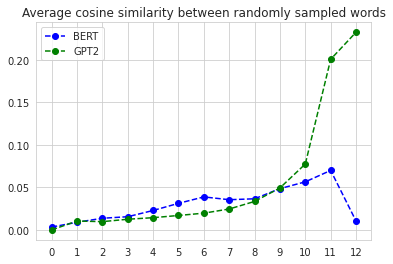

In [ ]:
#Строим график
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.plot(list(range(bert_mean_similarity_random_words.shape[0])), 
         bert_mean_similarity_random_words, 
         label='BERT', c='blue', linestyle='--',marker='.', ms=12)


plt.plot(list(range(gpt2_mean_similarity_random_words.shape[0])), 
         gpt2_mean_similarity_random_words, 
         label='GPT2', c='green', linestyle='--',marker='.', ms=12)


plt.title('Average cosine similarity between randomly sampled words')

plt.xticks(range(13))
plt.legend(loc='best')

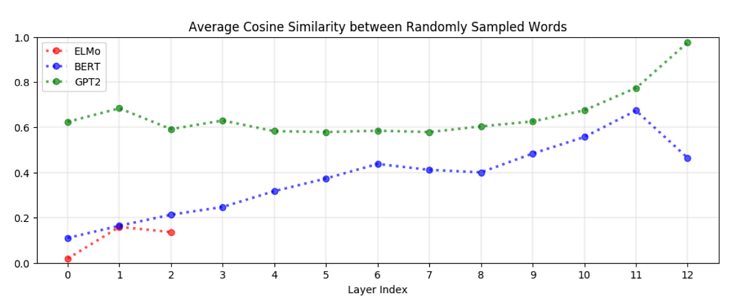

Рисунок 1 из статьи

Теперь займемся "близостью слов к самим себе" (self-similarity)

In [ ]:
from collections import defaultdict
#Функция для каждого токена записывает индексы предложений, где он встречался, и позицию в них
#В нее подается корпус и функция-токенайзер
def get_occurrences(corpus, tokenize):
    tokens_occurences = defaultdict(list)
    for ii, sentence in enumerate(corpus):
        tokens = tokenize(sentence)
        for jj, token in enumerate(tokens):
            tokens_occurences[token].append((ii, jj))
    return tokens_occurences

In [ ]:
bert_occurences = get_occurrences(corpus, bert_tokenizer.tokenize)
gpt2_occurences = get_occurrences(corpus, gpt2_tokenizer.tokenize)

In [ ]:
#Подсчет self-similarity* для конкретного токена
def self_similarity_for_token(token, occurences, get_embeddings, baseline, n_runs=10):
    if token not in occurences:
        return None
    sims_list = []
    for _ in range(n_runs):
        #Берем 2 случайных появления этого токена в корпусе
        ind1, ind2 = np.random.randint(0, len(occurences[token]), 2)
        app1, app2 = occurences[token][ind1], occurences[token][ind2]

        #Получаем эмбеддинги
        _, embs1 = get_embeddings(corpus[app1[0]])
        _, embs2 = get_embeddings(corpus[app2[0]])

        #Магия numpy для косинусной близости
        sims_list.append(np.sum(embs1[:,app1[1],:] * embs2[:,app2[1],:], axis=1) 
                        / np.linalg.norm(embs1[:,app1[1],:]) 
                        / np.linalg.norm(embs2[:,app2[1],:]))
                        
    return np.mean(sims_list, axis=0) - baseline

Теперь можно строить график self-similarity для конкретного слова (токена). [Помним, что некоторые слова могут токенизироваться по-разному в разных моделях, поэтому надо знать, что этот токен есть в обеих моделях]

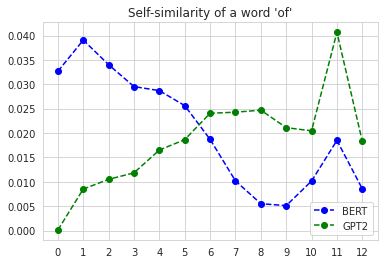

In [ ]:
word = 'of'
bert_self_sim = self_similarity_for_token(word, bert_occurences, get_bert_embeddings, bert_mean_similarity_random_words)
gpt2_self_sim = self_similarity_for_token(word, gpt2_occurences, get_gpt2_embeddings, gpt2_mean_similarity_random_words)
#Строим график

plt.plot(list(range(bert_self_sim.shape[0])), 
         bert_self_sim, 
         label='BERT', c='blue', linestyle='--',marker='.', ms=12)


plt.plot(list(range(gpt2_self_sim.shape[0])), 
         gpt2_self_sim, 
         label='GPT2', c='green', linestyle='--',marker='.', ms=12)


plt.title('Self-similarity of a word \'' + word + '\'')

plt.xticks(range(13))
plt.legend(loc='best')

In [ ]:
#Функция для подсчета средней косинусной близости "к самому себе"
def self_similarity(occurences, get_embeddings, baseline, n_runs=10, n_runs_for_token=10):
    sims_list = []
    for _ in range(n_runs):
        token = np.random.choice(list(occurences.keys()), 1)[0]
        sims_list.append(self_similarity_for_token(token, occurences, get_embeddings, baseline, n_runs_for_token))
    return np.mean(sims_list, axis=0)

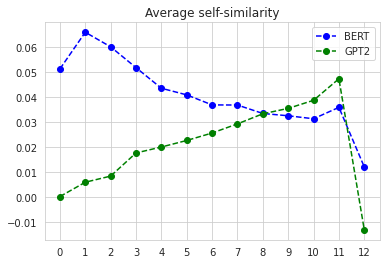

In [ ]:

bert_self_sim = self_similarity(bert_occurences, get_bert_embeddings, bert_mean_similarity_random_words,n_runs=100, n_runs_for_token=1)
gpt2_self_sim = self_similarity(gpt2_occurences, get_gpt2_embeddings, gpt2_mean_similarity_random_words,n_runs=100, n_runs_for_token=1)
#Строим график

plt.plot(list(range(bert_self_sim.shape[0])), 
         bert_self_sim, 
         label='BERT', c='blue', linestyle='--',marker='.', ms=12)


plt.plot(list(range(gpt2_self_sim.shape[0])), 
         gpt2_self_sim, 
         label='GPT2', c='green', linestyle='--',marker='.', ms=12)


plt.title('Average self-similarity')

plt.xticks(range(13))
plt.legend(loc='best')

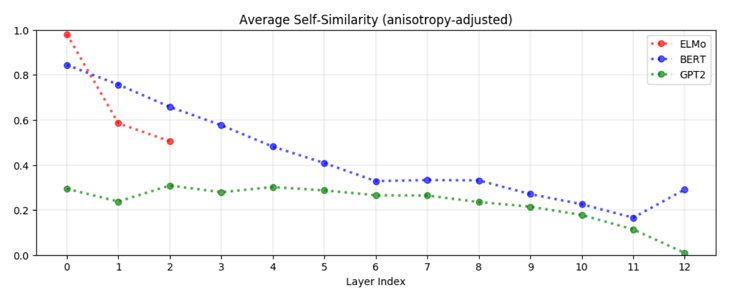

Рисунок 2 из статьи

Последний эксперимент - близость "внутри предложения" (intra-sentence similarity)



In [ ]:
#Функция для подсчета косинусной близости внутри поданного предложения
def sentence_similarity(sentence, get_embeddings, baseline):
  
  #Получаем тензор эмбеддингов
  tok, embs = get_embeddings(sentence)
  #Пользуемся формулой из Definition 2 и магией numpy
  s_l = embs.mean(1)
  int_sim = np.array([np.mean(np.sum(embs[l] * s_l[l], axis=1) / np.linalg.norm(s_l[l]) / np.linalg.norm(embs[l], axis=-1)) for l in range(s_l.shape[0])])
  #Не забываем про baseline
  int_sim -= baseline

  return int_sim

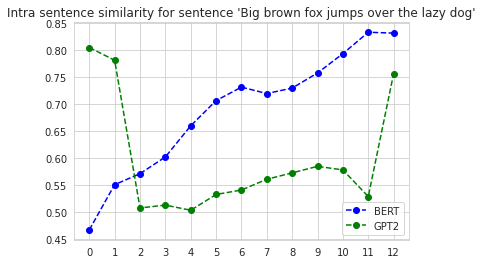

In [ ]:
sentence = 'Big brown fox jumps over the lazy dog'
bert_sent_sim = sentence_similarity(sentence, get_bert_embeddings, bert_mean_similarity_random_words)
gpt2_sent_sim = sentence_similarity(sentence, get_gpt2_embeddings, gpt2_mean_similarity_random_words)

#Строим график

plt.plot(list(range(bert_sent_sim.shape[0])), 
         bert_sent_sim, 
         label='BERT', c='blue', linestyle='--',marker='.', ms=12)


plt.plot(list(range(bert_sent_sim.shape[0])), 
         gpt2_sent_sim, 
         label='GPT2', c='green', linestyle='--',marker='.', ms=12)


plt.title('Intra sentence similarity for sentence \'' + sentence + '\'')

plt.xticks(range(13))
plt.legend(loc='best')

In [ ]:
#Функция для подсчета средней косинусной близости в предложении в поданном корпусе
def average_sentence_similarity(corpus, get_embeddings, baseline, n_runs=10):
    sims_list = []
    for _ in range(n_runs):
        sentence = np.random.choice(corpus, 1)[0]
        sims_list.append(sentence_similarity(sentence, get_embeddings, baseline))
    return np.mean(sims_list, axis=0)
  

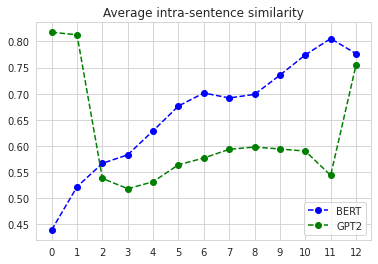

In [ ]:

bert_sent_sim = average_sentence_similarity(corpus, get_bert_embeddings, bert_mean_similarity_random_words)
gpt2_sent_sim = average_sentence_similarity(corpus, get_gpt2_embeddings, gpt2_mean_similarity_random_words)

#Строим график

plt.plot(list(range(bert_sent_sim.shape[0])), 
         bert_sent_sim, 
         label='BERT', c='blue', linestyle='--',marker='.', ms=12)


plt.plot(list(range(bert_sent_sim.shape[0])), 
         gpt2_sent_sim, 
         label='GPT2', c='green', linestyle='--',marker='.', ms=12)


plt.title('Average intra-sentence similarity')

plt.xticks(range(13))
plt.legend(loc='best')

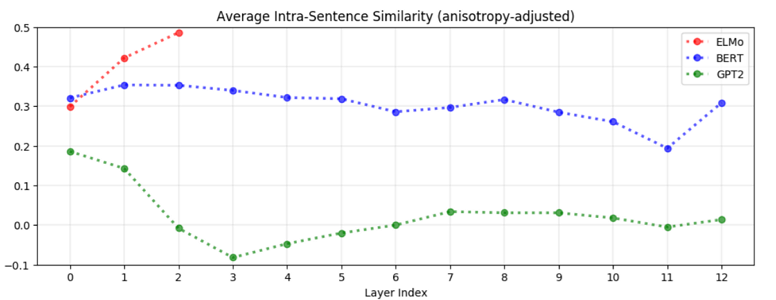

Рисунок 3 из статьи